In [10]:
import numpy as np
from matplotlib import pyplot as plt
import random
import gudhi as gd
import itertools

import tadasets
from datetime import datetime

import ecc_gudhi
import ecc_recursive
import ecc_sequential
import ecc_plot

In [11]:
# https://anaconda.org/conda-forge/memory_profiler
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


### NOTE: the ECC plot obtained via ecc_recursive contains more points that the one obtained from ecc_gudhi because ecc_gudhi only outputs the points in wich the EC changes values and discards thoose when the sum of the contributions equals 0

In [12]:
def compare_methods(points, epsilon, draw_lines=True):
    # ECC
    print("Star of the simplex - GUDHI")
    start=datetime.now()
    c_ls, ns_ls = ecc_gudhi.compute_local_contributions(points, epsilon)
    print("\t time:", datetime.now()-start)
     
    e_ls = ecc_plot.euler_characteristic_list_from_all(c_ls)
    print("\t simplicies found:          ", ns_ls)
    print("\t points in the ecc plot:    ", len(e_ls))
    
    ecc_plot.plot_euler_curve(e_ls, draw_lines, "Star of the simplex - GUDHI")
    
    # extend cliques recursively
    print("\nExtend cliques recursively - pure python")
    start=datetime.now()
    c = ecc_recursive.compute_local_contributions(points, epsilon)
    print("\t time:", datetime.now()-start)
    # the number of simplicies is equal to contributions list lenght
    print("\t simplicies found:          ", len(c))
    
    e_cc = ecc_plot.euler_characteristic_list_from_all(c)
    reduced_ecc = [e_cc[0]]
    for i, point in enumerate(e_cc[1:]):
        if point[1] != e_cc[i][1]:
            reduced_ecc.append(point)
    print("\t points in the ecc plot:    ", len(reduced_ecc))
    
    ecc_plot.plot_euler_curve(reduced_ecc, draw_lines, "Extend cliques recursively - pure python")
    
    # extend cliques sequentially
    print("\nExtend cliques sequentially - pure python")
    start=datetime.now()
    c_seq, ns_seq = ecc_sequential.compute_local_contributions(points, epsilon)
    print("\t time:", datetime.now()-start)
    print("\t simplicies found:          ", ns_seq)
    
    e_seq = ecc_plot.euler_characteristic_list_from_all(c_seq)
    print("\t points in the ecc plot:    ", len(e_seq))
    
    ecc_plot.plot_euler_curve(e_seq, draw_lines, "Extend cliques sequentially - pure python")
    
    print('')
    print('Consistency tests')
    print('Number of simplices: {}'.format(ns_ls==len(c)==ns_seq))
    print('ECC consistence    : {}'.format(e_ls==reduced_ecc==e_seq))

## Triangle

In [13]:
point_cloud = np.array([[0, 0], [4,0], [0,3] ])

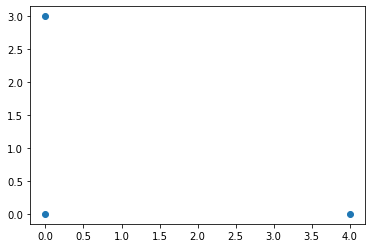

In [14]:
plt.scatter(point_cloud[: , 0], point_cloud[: , 1])

Star of the simplex - GUDHI
	 time: 0:00:00.000535
	 simplicies found:           7
	 points in the ecc plot:     3

Extend cliques recursively - pure python
	 time: 0:00:00.000324
	 simplicies found:           7
	 points in the ecc plot:     3

Extend cliques sequentially - pure python
	 time: 0:00:00.000677
	 simplicies found:           7
	 points in the ecc plot:     3

Consistency tests
Number of simplices: True
ECC consistence    : True


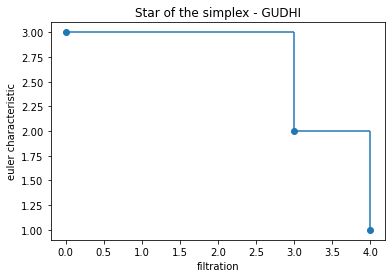

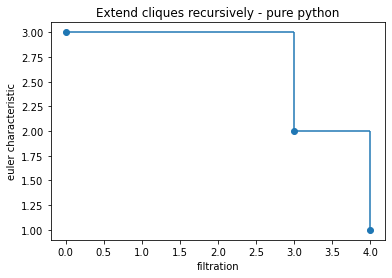

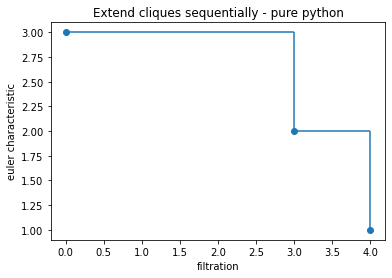

In [15]:
compare_methods(point_cloud, 10)

## Rhomboid

In [7]:
point_cloud = np.array([[4,0], [0,3.5], [-2, 0], [-0.5, -3]])

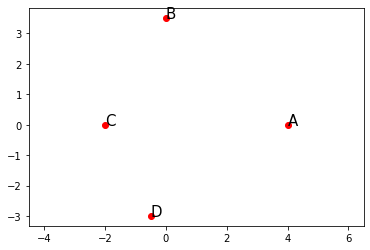

In [8]:
plt.axis('equal')
labels = ["A", "B", "C", "D"]
for i in range(len(point_cloud)):
    plt.scatter(point_cloud[i][0], point_cloud[i][1], color = "red")
    plt.text(point_cloud[i][0], point_cloud[i][1], labels[i], fontsize =15)


Star of the simplex - GUDHI
	 time: 0:00:00.016776
	 simplicies found:           15
	 points in the ecc plot:     6

Extend cliques recursively - pure python
	 time: 0:00:00.000670
	 simplicies found:           15
	 points in the ecc plot:     6

Extend cliques sequentially - pure python
	 time: 0:00:00.001443
	 simplicies found:           15
	 points in the ecc plot:     6

Extend cliques sequentially - slimmed - pure python
	 time: 0:00:00.001310
	 simplicies found:           15
	 points in the ecc plot:     6

Consistency tests
Number of simplices: True
ECC consistence    : True


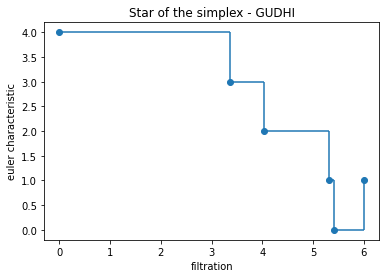

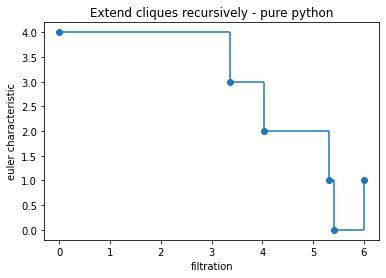

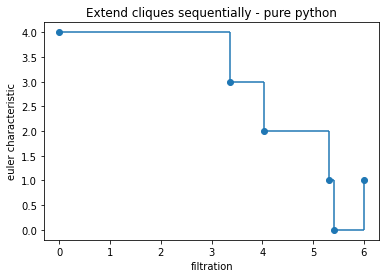

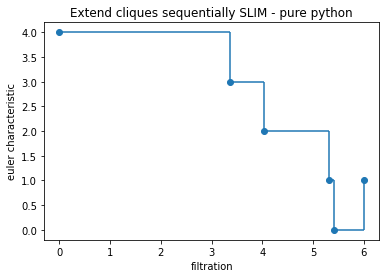

In [9]:
compare_methods(point_cloud, 10)

## Tetrahedron

In [10]:
point_cloud = np.array([[0,0,0], [0,1,0], [2,0,0], [0,0,3]])

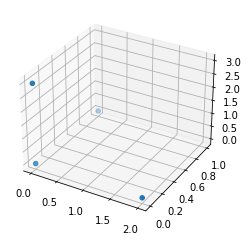

In [11]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter([x[0] for x in point_cloud], [x[1] for x in point_cloud], [x[2] for x in point_cloud])

Star of the simplex - GUDHI
	 time: 0:00:00.000657
	 simplicies found:           15
	 points in the ecc plot:     4

Extend cliques recursively - pure python
	 time: 0:00:00.000630
	 simplicies found:           15
	 points in the ecc plot:     4

Extend cliques sequentially - pure python
	 time: 0:00:00.001738
	 simplicies found:           15
	 points in the ecc plot:     4

Extend cliques sequentially - slimmed - pure python
	 time: 0:00:00.001094
	 simplicies found:           15
	 points in the ecc plot:     4

Consistency tests
Number of simplices: True
ECC consistence    : True


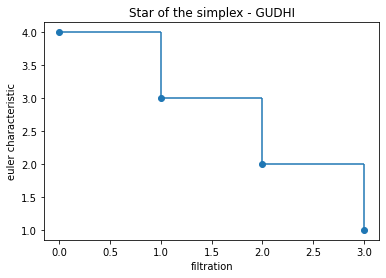

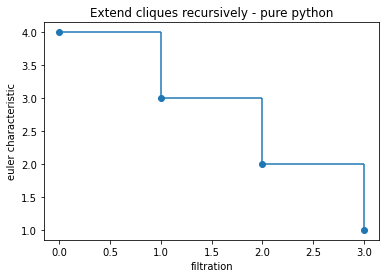

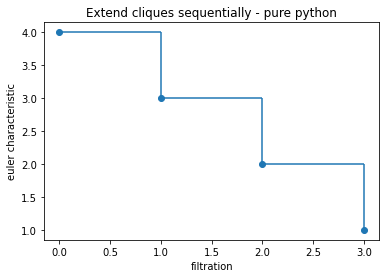

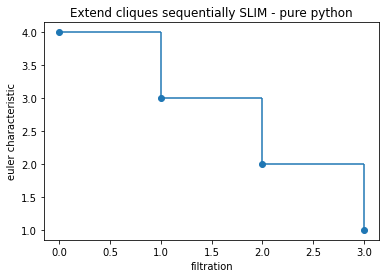

In [12]:
compare_methods(point_cloud, 10)

## Points from the example in the slides



In [13]:
point_cloud = np.array([[0,0], [2,-0.2], [4,0.2], [0,-1.5], [2,-3], [4,-1], [3.8,-2.5]] )

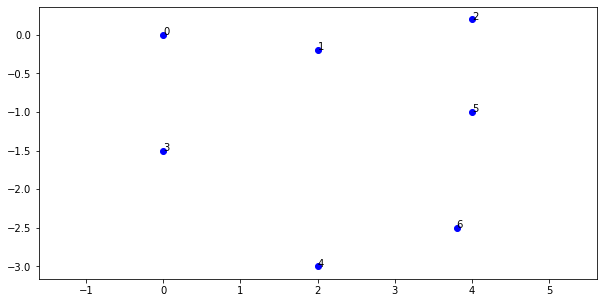

In [14]:
plt.figure(figsize=(10,5))
plt.axis('equal')
for i in range(len(point_cloud)):
    plt.scatter(point_cloud[i][0], point_cloud[i][1], color = "blue")
    plt.text(point_cloud[i][0], point_cloud[i][1], i)

Star of the simplex - GUDHI
	 time: 0:00:00.001871
	 simplicies found:           127
	 points in the ecc plot:     9

Extend cliques recursively - pure python
	 time: 0:00:00.002732
	 simplicies found:           127
	 points in the ecc plot:     9

Extend cliques sequentially - pure python
	 time: 0:00:00.006137
	 simplicies found:           127
	 points in the ecc plot:     9

Extend cliques sequentially - slimmed - pure python
	 time: 0:00:00.004063
	 simplicies found:           127
	 points in the ecc plot:     9

Consistency tests
Number of simplices: True
ECC consistence    : True


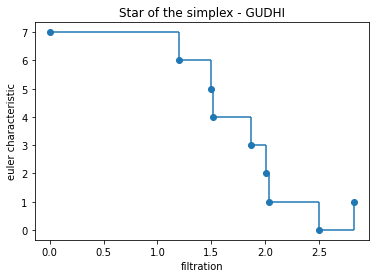

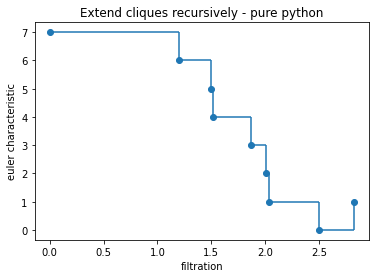

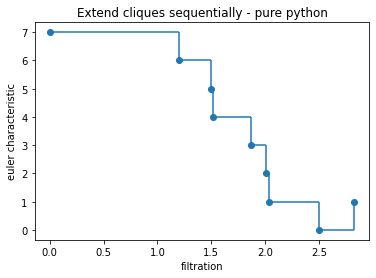

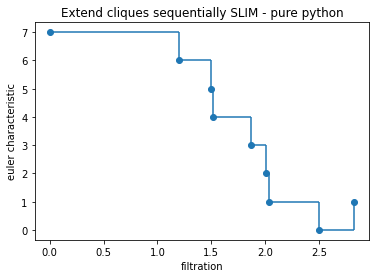

In [16]:
compare_methods(point_cloud, 10)

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Circle

In [18]:
point_cloud = []

NUMBER_OF_POINTS = 100

random.seed(42)
for i in range(NUMBER_OF_POINTS):
    angle = random.uniform(0,2*np.pi)
    point_cloud.append([np.cos(angle), np.sin(angle)])
    
point_cloud = np.array(point_cloud)

#np.savetxt('circle.csv', point_cloud, fmt='%f', delimiter=',')

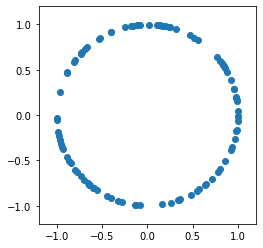

In [19]:
plt.axis('scaled')
plt.xlim((-1.2,1.2))
plt.ylim((-1.2,1.2))
plt.scatter(point_cloud[:,0], point_cloud[:,1])

In [20]:
points = point_cloud
epsilon = 0.75
draw_lines = False

Star of the simplex - GUDHI
	 time: 0:00:30.528474
	 simplicies found:           3328672
	 points in the ecc plot:     101

Extend cliques recursively - pure python
	 time: 0:00:45.088288
	 simplicies found:           3328672
	 points in the ecc plot:     101

Extend cliques sequentially - pure python
	 time: 0:06:31.681725
	 simplicies found:           3328672
	 points in the ecc plot:     101

Extend cliques sequentially - slimmed - pure python
	 time: 0:04:12.616667
	 simplicies found:           3328672
	 points in the ecc plot:     101

Consistency tests
Number of simplices: True
ECC consistence    : True


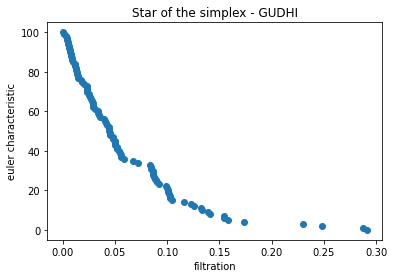

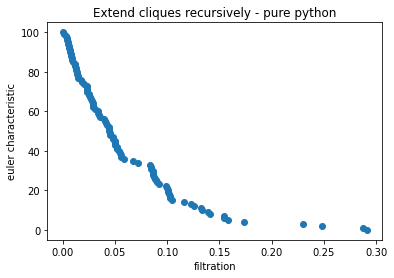

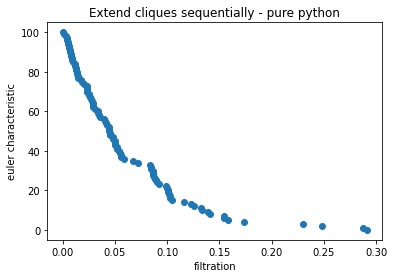

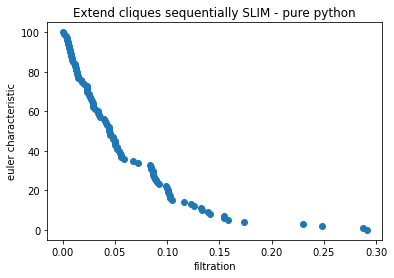

In [21]:
compare_methods(point_cloud, epsilon, draw_lines)

### we can use memory_profiler to monitor the RAM usage

In [22]:
%memit ecc_gudhi.compute_local_contributions(points, epsilon)

peak memory: 721.39 MiB, increment: 613.88 MiB


In [23]:
%memit ecc_recursive.compute_local_contributions(points, epsilon)

peak memory: 480.75 MiB, increment: 370.89 MiB


In [25]:
%memit ecc_sequential.compute_local_contributions(points, epsilon)

peak memory: 210.51 MiB, increment: 100.11 MiB


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## Double circle

In [4]:
point_cloud = []

NUMBER_OF_POINTS = 100

random.seed(42)
for i in range(NUMBER_OF_POINTS):
    angle = random.uniform(0,2*np.pi)
    point_cloud.append([np.cos(angle), np.sin(angle)])
    
    angle = random.uniform(0,2*np.pi)
    point_cloud.append([2*np.cos(angle), 5*np.sin(angle)])
    
    
point_cloud = np.array(point_cloud)

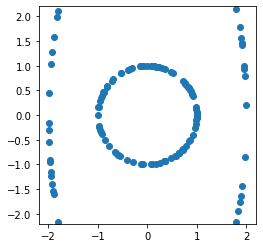

In [5]:
plt.axis('scaled')
plt.xlim((-2.2,2.2))
plt.ylim((-2.2,2.2))
plt.scatter(point_cloud[:, 0], point_cloud[:, 1])

Star of the simplex - GUDHI
	 time: 0:00:31.237782
	 simplicies found:           3572125
	 points in the ecc plot:     198

Extend cliques recursively - pure python
	 time: 0:01:09.564302
	 simplicies found:           3572125
	 points in the ecc plot:     198

Extend cliques sequentially - pure python
	 time: 0:07:04.959582
	 simplicies found:           3572125
	 points in the ecc plot:     198

Extend cliques sequentially - slimmed - pure python
	 time: 0:04:11.165979
	 simplicies found:           3572125
	 points in the ecc plot:     198

Consistency tests
Number of simplices: True
ECC consistence    : True


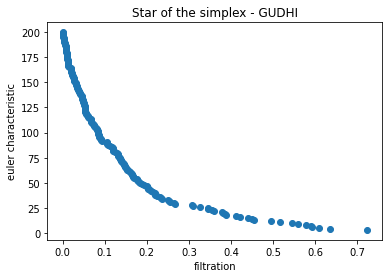

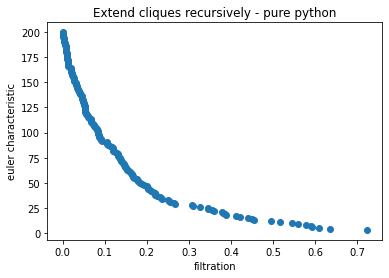

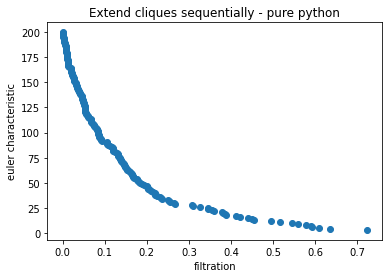

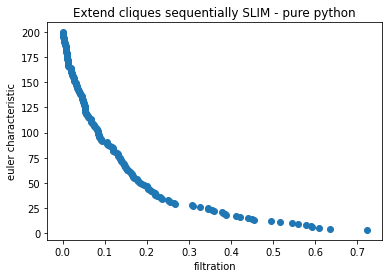

In [19]:
compare_methods(point_cloud, 0.75, draw_lines=False)

In [6]:
%memit ecc_gudhi.compute_local_contributions(point_cloud, 1)

peak memory: 6869.02 MiB, increment: 6790.88 MiB


In [7]:
%memit ecc_recursive.compute_local_contributions(point_cloud, 1)

peak memory: 7286.71 MiB, increment: 7195.15 MiB


In [8]:
# this is an old version, with also edges (j, i) with j > i
%memit ecc_sequential_OLD.compute_local_contributions(point_cloud, 1)

peak memory: 2006.98 MiB, increment: 1924.95 MiB


In [9]:
%memit ecc_sequential.compute_local_contributions(point_cloud, 1)

peak memory: 1528.57 MiB, increment: 1444.16 MiB


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# infinity

In [ ]:
point_cloud = tadasets.infty_sign(n=50, noise=None)

np.savetxt('infinity.csv', point_cloud, fmt='%f', delimiter=',')

In [ ]:
#plt.axis('scaled')
plt.scatter(point_cloud[:, 0], point_cloud[:, 1])

In [ ]:
compare_methods(point_cloud, 1)

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# n shpere

In [ ]:
point_cloud = tadasets.sphere(n=100, r=1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2])

np.savetxt('sphere.csv', point_cloud, fmt='%f', delimiter=',')

In [ ]:
compare_methods(point_cloud, .5, draw_lines=False)

# torus

In [ ]:
point_cloud = tadasets.torus(n=100, c=2, a=1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2])

np.savetxt('torus.csv', point_cloud, fmt='%f', delimiter=',')

## Hypercube

In [ ]:
# random points in the unit cube

N_POINTS = 100
DIMENSION = 3

np.random.seed(42)
point_cloud = np.random.rand(N_POINTS,DIMENSION)

In [ ]:
compare_methods(point_cloud, 0.6, draw_lines=False)

# GRID

In [ ]:
def create_grid(dim, lenght):
    # creates #dim arrays each of #lenght numbers at 0.1 distance
    # then staks them together

    return np.stack(np.meshgrid( *[[x/10 for x in range(lenght)] for i in range(dim)]  ), -1).reshape(-1, dim)

In [ ]:
point_cloud = create_grid(4, 5)

In [ ]:
compare_methods(point_cloud, 0.2)